# Modelo de Cámara Pinhole

Implementación del modelo matemático completo desde cero.

**Pipeline:**
$$P_{mundo}(X,Y,Z) \xrightarrow{[R|t]} P_{cámara}(X_c,Y_c,Z_c) \xrightarrow{K} p_{imagen}(u,v)$$

| Sección | Concepto |
|---------|----------|
| 1 | Proyección perspectiva básica: $x' = f \cdot X/Z$ |
| 2 | Matriz intrínseca $K$ → coordenadas en píxeles |
| 3 | Parámetros extrínsecos $[R \mid t]$ → movimiento de cámara |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # requerido para proyecciones 3D
import os

os.makedirs("media", exist_ok=True)

## 1. Proyección Perspectiva Básica

Modelo más simple del pinhole: un único parámetro $f$ (focal length).  
Por triángulos similares entre el punto 3D y su proyección en el plano focal:

$$x' = f \cdot \frac{X}{Z}, \qquad y' = f \cdot \frac{Y}{Z}$$

> A mayor $Z$ (punto más lejano), menor $x'/y'$ → **efecto de perspectiva**.

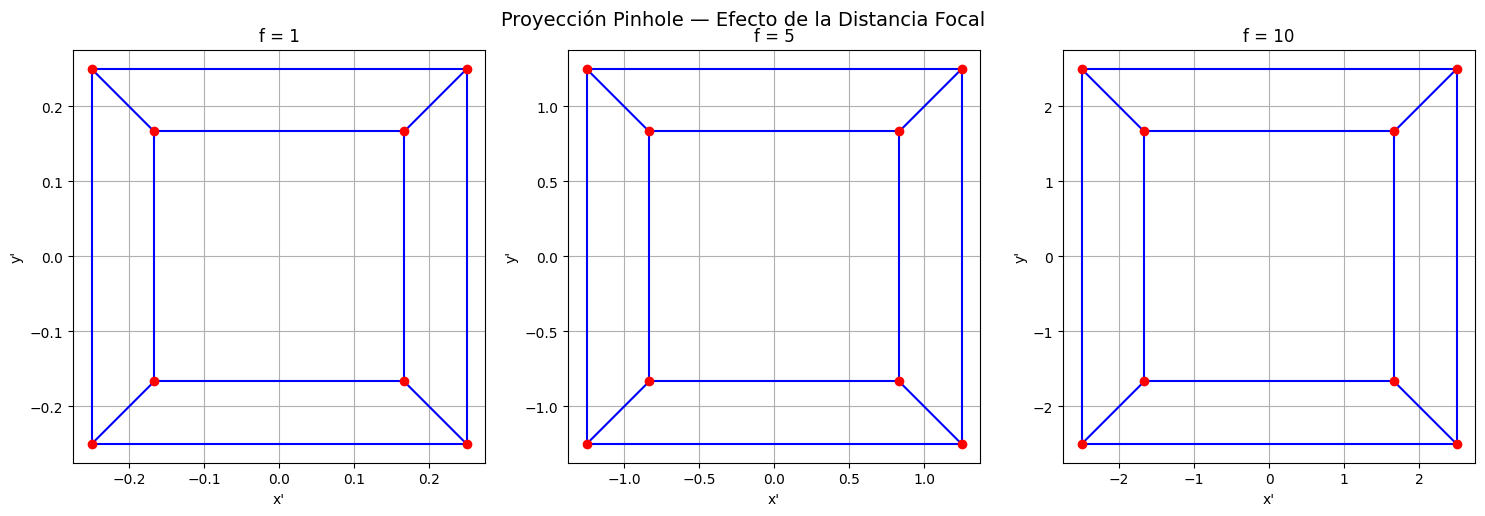

[OK] Imagen guardada: media/01_proyeccion_basica.png


In [2]:
def project_pinhole_basic(points_3d: np.ndarray, f: float) -> np.ndarray:
    """
    Proyección pinhole simple: x' = f * X/Z, y' = f * Y/Z

    Aplica las ecuaciones de perspectiva directamente sin matriz K.
    Resultado en unidades métricas (no píxeles).

    Args:
        points_3d: Array Nx3 con puntos 3D (X, Y, Z). Z debe ser > 0.
        f:         Distancia focal (mismas unidades que X, Y, Z).
    Returns:
        Array Nx2 con coordenadas proyectadas (x', y') en el plano focal.
    """
    X, Y, Z = points_3d[:, 0], points_3d[:, 1], points_3d[:, 2]
    # División por Z aplica la perspectiva: objetos más lejanos se ven más pequeños
    x_proj = f * X / Z
    y_proj = f * Y / Z
    return np.stack([x_proj, y_proj], axis=1)


def get_cube_edges():
    """
    Retorna vértices y aristas de un cubo unitario centrado en el origen.

    8 vértices = combinaciones de ±1 en los tres ejes.
    12 aristas: 4 cara frontal (z=+1), 4 cara trasera (z=-1), 4 laterales.
    """
    vertices = np.array([
        [-1, -1,  1], [ 1, -1,  1], [ 1,  1,  1], [-1,  1,  1],  # cara frontal (z=+1)
        [-1, -1, -1], [ 1, -1, -1], [ 1,  1, -1], [-1,  1, -1],  # cara trasera (z=-1)
    ], dtype=float)
    edges = [
        (0,1),(1,2),(2,3),(3,0),  # cara frontal
        (4,5),(5,6),(6,7),(7,4),  # cara trasera
        (0,4),(1,5),(2,6),(3,7),  # aristas laterales
    ]
    return vertices, edges


def demo_basic_projection():
    """
    Demo 1 — Efecto de la distancia focal en la proyección perspectiva.

    Se proyecta el cubo con tres valores de f para mostrar que:
      - f pequeño  → FOV amplio, objeto se ve pequeño en el plano focal
      - f grande   → FOV estrecho (zoom), objeto se ve más grande
    """
    vertices, edges = get_cube_edges()
    # Trasladar el cubo al frente de la cámara: Z ∈ [4, 6]
    vertices_world = vertices + np.array([0, 0, 5])

    focal_lengths = [1, 5, 10]  # tres distancias focales para comparar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Proyección Pinhole — Efecto de la Distancia Focal", fontsize=14)

    for ax, f in zip(axes, focal_lengths):
        proj = project_pinhole_basic(vertices_world, f)
        for i, j in edges:
            ax.plot([proj[i, 0], proj[j, 0]], [proj[i, 1], proj[j, 1]], 'b-')
        ax.scatter(proj[:, 0], proj[:, 1], c='red', zorder=5)
        ax.set_title(f"f = {f}")
        ax.set_xlabel("x'"); ax.set_ylabel("y'")
        ax.set_aspect('equal'); ax.grid(True)

    plt.tight_layout()
    plt.savefig("media/01_proyeccion_basica.png", dpi=150)
    plt.show()
    print("[OK] Imagen guardada: media/01_proyeccion_basica.png")


demo_basic_projection()


## 2. Matriz Intrínseca $K$

$K$ convierte coordenadas métricas normalizadas a **píxeles**:

$$K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
\quad\Rightarrow\quad
u = f_x\frac{X_c}{Z_c} + c_x, \quad v = f_y\frac{Y_c}{Z_c} + c_y$$

| Parámetro | Significado |
|-----------|-------------|
| $f_x, f_y$ | Focal length en píxeles (si $f_x \neq f_y$ → sensor anamórfico) |
| $c_x, c_y$ | Punto principal: intersección del eje óptico con el sensor |

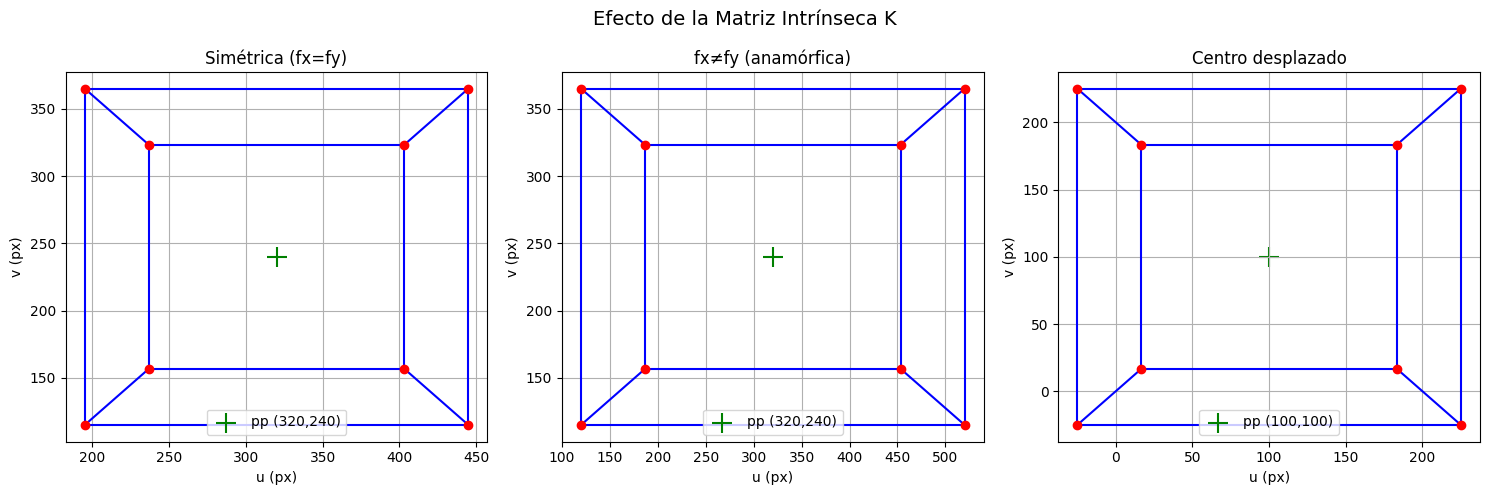

[OK] Imagen guardada: media/02_matriz_intrinseca.png


In [3]:
def build_K(fx: float, fy: float, cx: float, cy: float) -> np.ndarray:
    """
    Construye la matriz intrínseca K 3×3.

    Args:
        fx: Focal length en píxeles sobre el eje X.
        fy: Focal length en píxeles sobre el eje Y.
        cx: Coordenada X del punto principal (en px).
        cy: Coordenada Y del punto principal (en px).
    Returns:
        Matriz K (3×3) de tipo float64.
    """
    return np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ], dtype=float)


def project_with_K(points_3d: np.ndarray, K: np.ndarray) -> np.ndarray:
    """
    Proyecta puntos 3D a coordenadas de imagen (píxeles) usando la matriz K.

    Asume que los puntos YA están en el sistema de referencia de la cámara.
    Proceso:
        1. División perspectiva: xn = Xc/Zc, yn = Yc/Zc
        2. Transformación a píxeles: u = fx·xn + cx, v = fy·yn + cy

    Args:
        points_3d: Array Nx3 en coordenadas de cámara (Xc, Yc, Zc).
        K:         Matriz intrínseca 3×3.
    Returns:
        Array Nx2 con coordenadas en píxeles (u, v).
    """
    X, Y, Z = points_3d[:, 0], points_3d[:, 1], points_3d[:, 2]
    # Paso 1: dividir por Z → coordenadas normalizadas
    x_norm = X / Z
    y_norm = Y / Z
    # Paso 2: aplicar focal length y desplazar por punto principal
    u = K[0, 0] * x_norm + K[0, 2]  # u = fx·xn + cx
    v = K[1, 1] * y_norm + K[1, 2]  # v = fy·yn + cy
    return np.stack([u, v], axis=1)


def demo_intrinsic_matrix():
    """
    Demo 2 — Efecto de distintos parámetros intrínsecos K.

    Tres configuraciones:
      1. Simétrica        : fx = fy, punto principal centrado → proyección neutra
      2. Anamórfica       : fx ≠ fy → imagen estirada horizontalmente
      3. Centro desplazado: cx/cy fuera del centro → imagen desplazada en el sensor
    El punto principal se marca en verde (+).
    """
    vertices, edges = get_cube_edges()
    vertices_cam = vertices + np.array([0, 0, 5])  # cubo en coordenadas de cámara

    configs = [
        {"fx": 500, "fy": 500, "cx": 320, "cy": 240, "label": "Simétrica (fx=fy)"},
        {"fx": 800, "fy": 500, "cx": 320, "cy": 240, "label": "fx≠fy (anamórfica)"},
        {"fx": 500, "fy": 500, "cx": 100, "cy": 100, "label": "Centro desplazado"},
    ]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("Efecto de la Matriz Intrínseca K", fontsize=14)

    for ax, cfg in zip(axes, configs):
        K = build_K(cfg["fx"], cfg["fy"], cfg["cx"], cfg["cy"])
        proj = project_with_K(vertices_cam, K)
        for i, j in edges:
            ax.plot([proj[i, 0], proj[j, 0]], [proj[i, 1], proj[j, 1]], 'b-')
        ax.scatter(proj[:, 0], proj[:, 1], c='red', zorder=5)
        # Marcar punto principal (cx, cy) — intersección eje óptico con sensor
        ax.scatter(cfg["cx"], cfg["cy"], c='green', marker='+', s=200,
                   label=f"pp ({cfg['cx']},{cfg['cy']})")
        ax.set_title(cfg["label"])
        ax.set_xlabel("u (px)"); ax.set_ylabel("v (px)")
        ax.legend(); ax.grid(True)

    plt.tight_layout()
    plt.savefig("media/02_matriz_intrinseca.png", dpi=150)
    plt.show()
    print("[OK] Imagen guardada: media/02_matriz_intrinseca.png")


demo_intrinsic_matrix()


## 3. Parámetros Extrínsecos $[R \mid t]$

Describen la **pose** de la cámara en el mundo:

$$P_{cam} = R \cdot P_{mundo} + t$$

| Componente | Rol | Grados de libertad |
|------------|-----|--------------------|
| $R$ (3×3) | Orientación de la cámara (ortogonal, $\det=+1$) | 3 (pitch/yaw/roll) |
| $t$ (3×1) | Posición del centro óptico en el mundo | 3 |

Las rotaciones elementales por eje ($R_x, R_y, R_z$) se pueden componer para cualquier orientación: $R = R_z R_y R_x$.

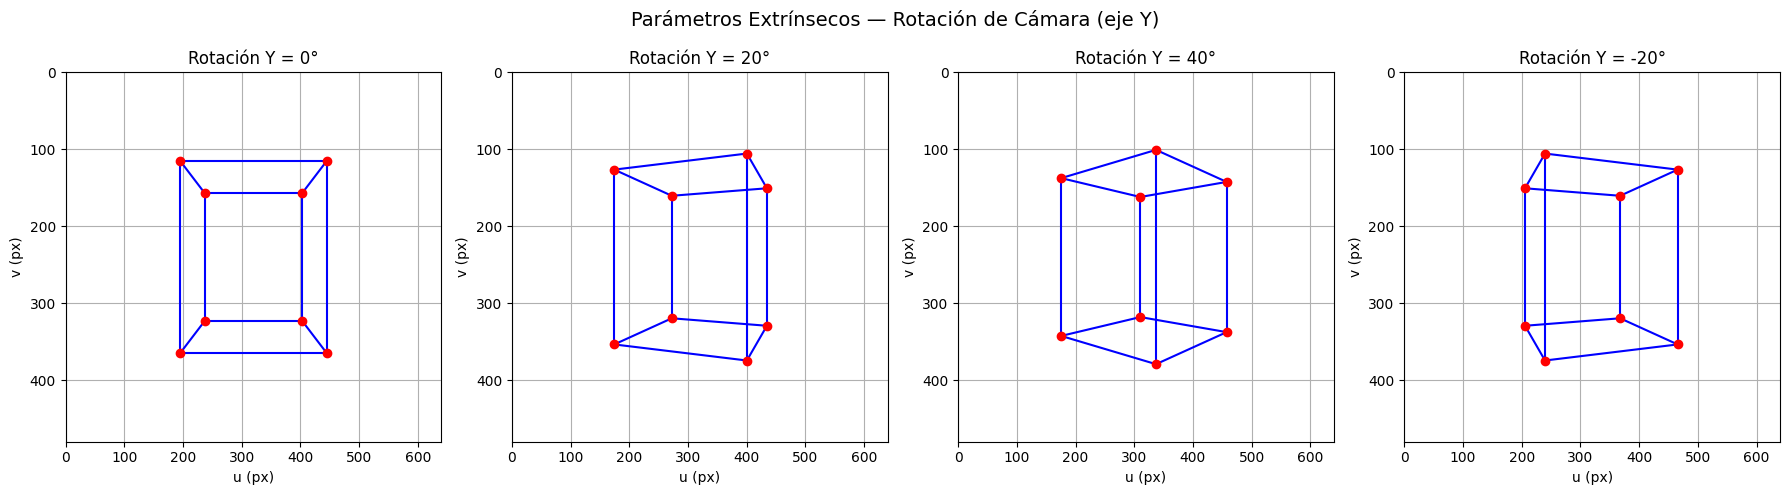

[OK] Imagen guardada: media/03_extrinsecos.png


In [4]:
def rotation_matrix_x(angle_deg: float) -> np.ndarray:
    """
    Matriz de rotación 3×3 alrededor del eje X (pitch).

    Rx = | 1    0       0   |
         | 0  cos(α) -sin(α)|
         | 0  sin(α)  cos(α)|
    """
    a = np.radians(angle_deg)
    return np.array([
        [1,       0,        0],
        [0, np.cos(a), -np.sin(a)],
        [0, np.sin(a),  np.cos(a)],
    ])

def rotation_matrix_y(angle_deg: float) -> np.ndarray:
    """
    Matriz de rotación 3×3 alrededor del eje Y (yaw).

    Ry = | cos(β)  0  sin(β)|
         |   0     1    0   |
         |-sin(β)  0  cos(β)|
    """
    a = np.radians(angle_deg)
    return np.array([
        [ np.cos(a), 0, np.sin(a)],
        [       0,   1,       0  ],
        [-np.sin(a), 0, np.cos(a)],
    ])

def rotation_matrix_z(angle_deg: float) -> np.ndarray:
    """
    Matriz de rotación 3×3 alrededor del eje Z (roll).

    Rz = | cos(γ) -sin(γ)  0|
         | sin(γ)  cos(γ)  0|
         |   0       0     1|
    """
    a = np.radians(angle_deg)
    return np.array([
        [np.cos(a), -np.sin(a), 0],
        [np.sin(a),  np.cos(a), 0],
        [       0,         0,   1],
    ])


def world_to_camera(points_world: np.ndarray, R: np.ndarray, t: np.ndarray) -> np.ndarray:
    """
    Transforma puntos del sistema mundo al sistema cámara.

    Fórmula: P_cam = R @ P_world + t
      - R rota el sistema de referencia (orienta la cámara).
      - t desplaza el origen (posición de la cámara en el mundo).

    Args:
        points_world: Array Nx3 en coordenadas mundo.
        R:            Matriz de rotación 3×3 (ortogonal, det=+1).
        t:            Vector de traslación (3,).
    Returns:
        Array Nx3 en coordenadas de cámara.
    """
    # (R @ points_world.T) → 3×N, luego .T → N×3; + t hace broadcast por fila
    return (R @ points_world.T).T + t


def project_full_pipeline(points_world, K, R, t):
    """
    Pipeline completo de proyección: mundo 3D → píxeles 2D.

    Etapas:
        1. world_to_camera : aplica [R|t]  → coordenadas de cámara
        2. project_with_K  : aplica K      → coordenadas de imagen (píxeles)

    Args:
        points_world: Array Nx3 en coordenadas mundo.
        K:            Matriz intrínseca 3×3.
        R:            Matriz de rotación extrínseca 3×3.
        t:            Vector de traslación extrínseco (3,).
    Returns:
        Array Nx2 con coordenadas (u, v) en píxeles.
    """
    pts_cam = world_to_camera(points_world, R, t)  # paso extrínseco
    return project_with_K(pts_cam, K)              # paso intrínseco


def demo_extrinsics():
    """
    Demo 3 — Simulación de movimiento de cámara (rotación Ry) alrededor del cubo.

    La cámara orbita rotando en Y con ángulos [0°, 20°, 40°, -20°]:
      - 0°  → vista frontal
      - 20° → perspectiva leve desde la derecha
      - 40° → perspectiva marcada
      - -20° → perspectiva desde la izquierda
    Se usa invert_yaxis() para seguir la convención de imagen (Y crece hacia abajo).
    """
    vertices, edges = get_cube_edges()
    K = build_K(fx=500, fy=500, cx=320, cy=240)  # sensor 640×480 px, focal 500 px
    t = np.array([0, 0, 5])  # cámara a 5 unidades frente al cubo

    angles = [0, 20, 40, -20]
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle("Parámetros Extrínsecos — Rotación de Cámara (eje Y)", fontsize=14)

    for ax, ang in zip(axes, angles):
        R = rotation_matrix_y(ang)                         # rotar cámara ang° en Y
        proj = project_full_pipeline(vertices, K, R, t)   # pipeline completo
        for i, j in edges:
            ax.plot([proj[i, 0], proj[j, 0]], [proj[i, 1], proj[j, 1]], 'b-')
        ax.scatter(proj[:, 0], proj[:, 1], c='red', zorder=5)
        ax.set_title(f"Rotación Y = {ang}°")
        ax.set_xlabel("u (px)"); ax.set_ylabel("v (px)")
        ax.set_xlim(0, 640); ax.set_ylim(0, 480)
        ax.invert_yaxis()  # convención imagen: origen arriba-izquierda
        ax.grid(True)

    plt.tight_layout()
    plt.savefig("media/03_extrinsecos.png", dpi=150)
    plt.show()
    print("[OK] Imagen guardada: media/03_extrinsecos.png")


demo_extrinsics()
